In [0]:
# Check if optional dependencies are installed
try:
    import matplotlib.pyplot as plt
    import pyarrow.parquet as pq
except ImportError:
    print('Optional dependencies are not installed. Please install them to create this plot.')

# Import required libraries
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.stats import norm, gaussian_kde
from pathlib import Path

### Function to create variance based sample plot

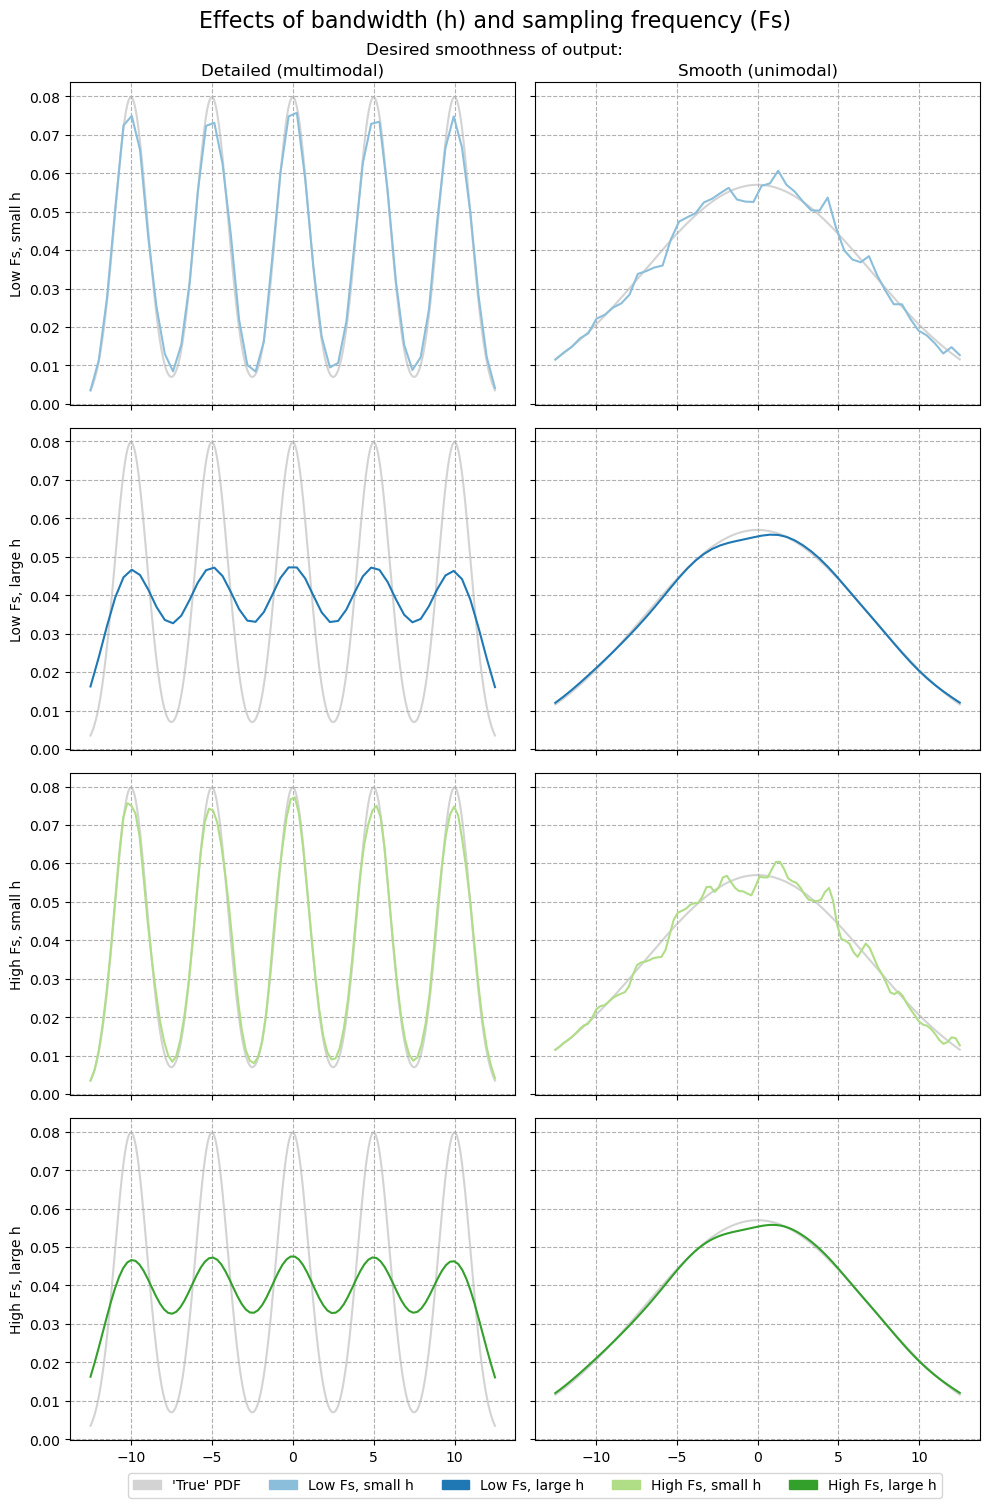

Number of measurement locations for small grid: 50, distance between them: 0.51
Number of measurement locations for large grid: 100, distance between them: 0.25
Small bandwidth: 0.04, Large bandwidth: 0.2


In [0]:
def plot_variance_based_sampling_example() -> None:
    
    # Set np seed
    np.random.seed(12345)

    # Define the x values covering the range of interest
    x_min, x_max = -12.5, 12.5
    x = np.linspace(x_min, x_max, 10000)

    # Define four normal distributions with means close together
    dist1_narrow = norm(loc=-10, scale=1)
    dist2_narrow = norm(loc=-5, scale=1)
    dist3_narrow = norm(loc=0, scale=1)
    dist4_narrow = norm(loc=5, scale=1)
    dist5_narrow = norm(loc=10, scale=1)

    # Compute the "true" PDF as the average of the five individual PDFs
    true_pdf_narrow = (dist1_narrow.pdf(x) + dist2_narrow.pdf(x) + dist3_narrow.pdf(x) + dist4_narrow.pdf(x) + dist5_narrow.pdf(x)) / 5
    
    # Define a single broad normal distribution
    dist_broad = norm(loc=0, scale=7)

    # Compute the "true" PDF from the broad spread distribution
    true_pdf_broad = dist_broad.pdf(x)
    
    # Create actual sample from both distributions
    n_samples = 10000

    # Create samples from the narrow and broad spread distributions
    samples_narrow = np.concatenate([dist1_narrow.rvs(n_samples // 5),
                                    dist2_narrow.rvs(n_samples // 5),
                                    dist3_narrow.rvs(n_samples // 5),
                                    dist4_narrow.rvs(n_samples // 5),
                                    dist5_narrow.rvs(n_samples // 5)])
    samples_broad = dist_broad.rvs(n_samples)
    
    # Set number of voxels 
    number_of_voxels_small = 50
    number_of_voxels_large = 100

    # Set bandwidth sizes for the KDE
    small_bw = 0.04
    large_bw = 0.2

    # Generate measurement locations
    x_small = np.linspace(x_min, x_max, number_of_voxels_small)
    x_large = np.linspace(x_min, x_max, number_of_voxels_large)
    
    # Set up KDE objects for the narrow and broad spread samples, using Silverman for both
    kde_narrow_small_bw = gaussian_kde(samples_narrow, bw_method=small_bw)
    kde_broad_small_bw = gaussian_kde(samples_broad, bw_method=small_bw)


    kde_broad_large_bw = gaussian_kde(samples_broad, bw_method=large_bw)
    kde_narrow_large_bw = gaussian_kde(samples_narrow, bw_method=large_bw)

    # Compute the KDEs at the measurement locations
    kde_narrow_small_grid_small_bw = kde_narrow_small_bw(x_small)
    kde_narrow_small_grid_large_bw = kde_narrow_large_bw(x_small)
    kde_narrow_large_grid_small_bw = kde_narrow_small_bw(x_large)
    kde_narrow_large_grid_large_bw = kde_narrow_large_bw(x_large)

    kde_broad_small_grid_small_bw = kde_broad_small_bw(x_small)
    kde_broad_small_grid_large_bw = kde_broad_large_bw(x_small)
    kde_broad_large_grid_small_bw = kde_broad_small_bw(x_large)
    kde_broad_large_grid_large_bw = kde_broad_large_bw(x_large)
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(4, 2, figsize=(10, 15), sharey=True, sharex=True)

    # Add main title to the figure
    fig.suptitle('Effects of bandwidth (h) and sampling frequency (Fs)', fontsize=16)

    # Add subtitle below the main title
    fig.text(0.5, 0.95, 'Desired smoothness of output:', ha='center', fontsize=12)

    # Lists for looping through the KDEs
    # color_list = ['red', 'blue', 'green', 'yellow']
    color_list = [('#8bbeda'), ('#1F78B4'), ('#b0de87'), ('#33A02C')]
    kde_list_narrow = [kde_narrow_small_grid_small_bw, kde_narrow_small_grid_large_bw, kde_narrow_large_grid_small_bw, kde_narrow_large_grid_large_bw]
    kde_list_broad = [kde_broad_small_grid_small_bw, kde_broad_small_grid_large_bw, kde_broad_large_grid_small_bw, kde_broad_large_grid_large_bw]
    small_or_large = [x_small, x_small, x_large, x_large]

    # Plot the true PDFs and the grid for every plot
    for i in range(4):
        plt.sca(axs[i, 0])
        plt.plot(x, true_pdf_narrow, color='lightgrey', zorder=-14)
        plt.grid(True, linestyle='--', zorder=-15)
        plt.plot(small_or_large[i], kde_list_narrow[i], color=color_list[i])
        
        plt.sca(axs[i, 1])
        plt.plot(x, true_pdf_broad, color='lightgrey', zorder=-14)
        plt.grid(True, linestyle='--', zorder=-15)
        plt.plot(small_or_large[i], kde_list_broad[i], color=color_list[i])

    # Add column labels
    axs[0, 0].set_title('Detailed (multimodal)')
    axs[0, 1].set_title('Smooth (unimodal)')

    # Add row labels
    row_labels = ['Low Fs, small h', 'Low Fs, large h', 'High Fs, small h', 'High Fs, large h']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label)

    # Set to tight layout and add extra space at the bottom
    plt.tight_layout(rect=[0, 0, 1, 0.98]) 

    # Use patches to create custom legend labels
    patches = [mpatches.Patch(color=color_list[i], label=row_labels[i]) for i in range(4)]
    # Prepend the 'true' pdf label
    patches.insert(0, mpatches.Patch(color='lightgrey', label="'True' PDF"))

    # Place the legend at the bottom, centered
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0, -0.2), ncol=5)

    # Save fig and show
    plt.savefig(Path('output', 'variance_based_sampling_plot.png'), bbox_inches='tight', dpi=300)
    plt.show()

    # Print number of measurement locations, distance between them, and bandwidths
    print(f"Number of measurement locations for small grid: {number_of_voxels_small}, distance between them: {x_small[1] - x_small[0]:.2f}")
    print(f"Number of measurement locations for large grid: {number_of_voxels_large}, distance between them: {x_large[1] - x_large[0]:.2f}")
    print(f"Small bandwidth: {small_bw}, Large bandwidth: {large_bw}")
    
# Run function
plot_variance_based_sampling_example()